In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from utils import PCP, RLCP, CC, SCP, train_val_test_split
from coverage import wsc_unbiased
from datasets import datasets
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

In [3]:
alpha = 0.1
num_iterations = 200
dataset_base_path = "datasets/"
dataset_name = "superconductor"
X_, Y_ = datasets.GetDataset(dataset_name, dataset_base_path)

In [ ]:
seed = 123456
np.random.seed(seed)
c_1 =[]
c_2 = []
c_3 = []
c_4 = []

ml_scp =[]
ml_cc = []
ml_rlcp = []
ml_pcp = []

mc_scp = []
mc_cc = []
mc_rlcp = []
mc_pcp = []


pca = PCA(30)
pca.fit(X_[11000:])
X = pca.transform(X_[:11000])
Y = Y_[:11000]

for j in range(1,num_iterations +1):

    indices = np.random.permutation(11000)
    X_train, X_val, X_test, Y_train, Y_val, Y_test, _ = train_val_test_split(X[indices][:2000], Y[indices][:2000],1/4)


    RF =  Ridge(alpha=0.001).fit(X_train,Y_train)
    
    R_val = abs(Y_val - RF.predict(X_val))
    R_test = abs(Y_test - RF.predict(X_test))

    
    kf = KFold(n_splits=20, shuffle=True, random_state=seed)

    R_train = np.zeros_like(Y_train)
    

    for train_index, test_index in kf.split(X_train):

        RF_train = Ridge(alpha=0.001).fit(X_train[train_index],Y_train[train_index])
        R_train[test_index] = abs(Y_train[test_index] - RF_train.predict(X_train[test_index]))

    q_scp, coverage_scp = SCP(R_val, R_test, alpha, finite=True)
    lbs, ubs, length_cc, coverage_cc = CC(RF, X_val, Y_val,  X_test, Y_test, alpha, finite=True, exact=True)
    q_rlcp, coverage_rlcp = RLCP(X_train, X_val, R_val, X_test, R_test, alpha, finite=True)
    PCP_model = PCP()
    PCP_model.train(X_train,R_train)
    q_pcp, coverage_pcp = PCP_model.calibrate(X_val, R_val,X_test, R_test, alpha, finite=True)

    
    print("SCP:", 2 * np.mean(q_scp), "SCP+CC:", np.mean(length_cc), "RLCP:", 2 * np.mean(q_rlcp), "PCP:", 2 * np.mean(q_pcp))


    ml_scp.append(2*np.mean(q_scp))
    ml_cc.append(np.mean(length_cc))
    ml_rlcp.append(2*np.mean(q_rlcp))
    ml_pcp.append(2*np.mean(q_pcp))


    mc_scp.append(np.mean(coverage_scp))
    mc_cc.append(np.mean(coverage_cc))
    mc_rlcp.append(np.mean(coverage_rlcp))
    mc_pcp.append(np.mean(coverage_pcp))
    
    c_1.append(wsc_unbiased(X_test,np.array(coverage_scp), M=2500))
    c_2.append(wsc_unbiased(X_test,np.array(coverage_cc), M=2500))
    c_3.append(wsc_unbiased(X_test,np.array(coverage_rlcp), M=2500))
    c_4.append(wsc_unbiased(X_test,np.array(coverage_pcp), M=2500))

    print("SCP:", np.mean(c_1), "SCP+CC:", np.mean(c_2), "RLCP:", np.mean(c_3), "PCP:", np.mean(c_4))

In [13]:
data = np.concatenate(
    [[mc_scp, num_iterations*['SCP']],
      [mc_cc, num_iterations*['SCP+CC']],
      [mc_rlcp, num_iterations*['RLCP']],    
     [mc_pcp, num_iterations*['PCP']]
    ],axis=1)
df = pd.DataFrame(columns=['Coverage', 'Method'], data=data.T)
df['Coverage'] = df['Coverage'].astype("float64")

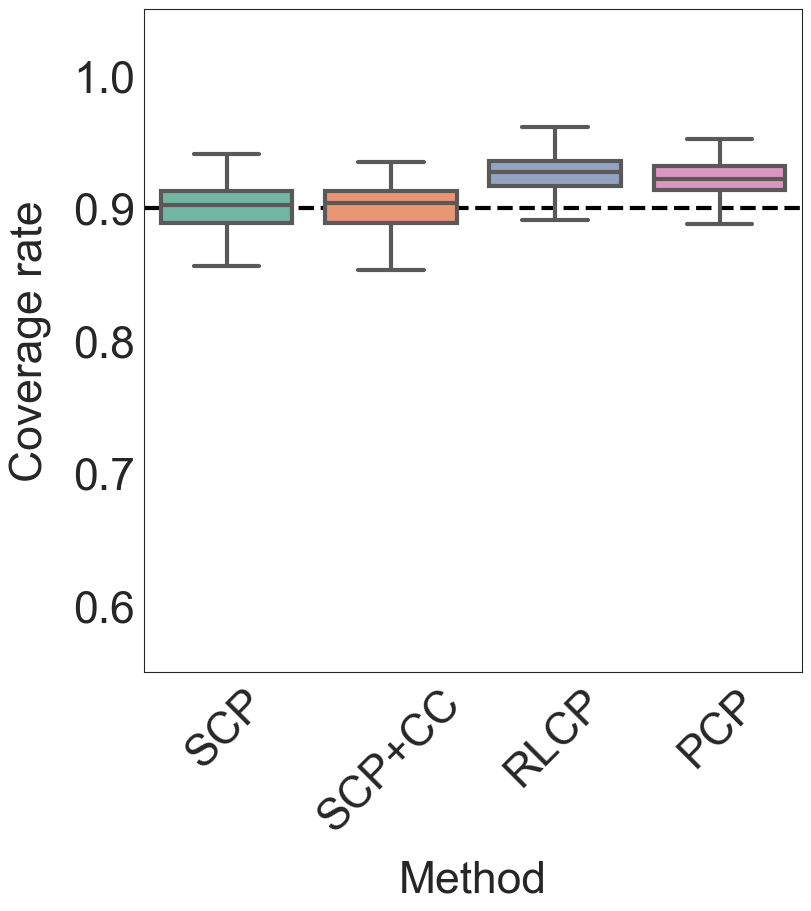

In [14]:
plt.figure(layout='constrained', figsize=(8,9))
plt.axhline(y=0.9, color='black', linestyle='--', linewidth=3) 
sns.set_style("white")
sns.color_palette("Set2")
sns.boxplot(y='Coverage', x='Method', data=df, fliersize=0,linewidth=3,palette="Set2")
plt.ylim([0.55,1.05])
plt.yticks([0.6, 0.7,0.8,0.9,1.0])
plt.xlabel('Method', fontsize=32, labelpad = 15)
plt.ylabel('Coverage rate', fontsize=32, labelpad = 15)
plt.yticks(fontsize=32)
plt.xticks(fontsize=32,rotation=45)

In [15]:
data1= np.concatenate([[ml_scp, num_iterations*['SCP']], [ml_cc, num_iterations*['SCP+CC']],[ml_rlcp, num_iterations*['RLCP']], [ml_pcp, num_iterations*['PCP']] ],axis=1)
df1 = pd.DataFrame(columns=['Width', 'Method'], data=data1.T)
df1['Width'] = df1['Width'].astype("float64")

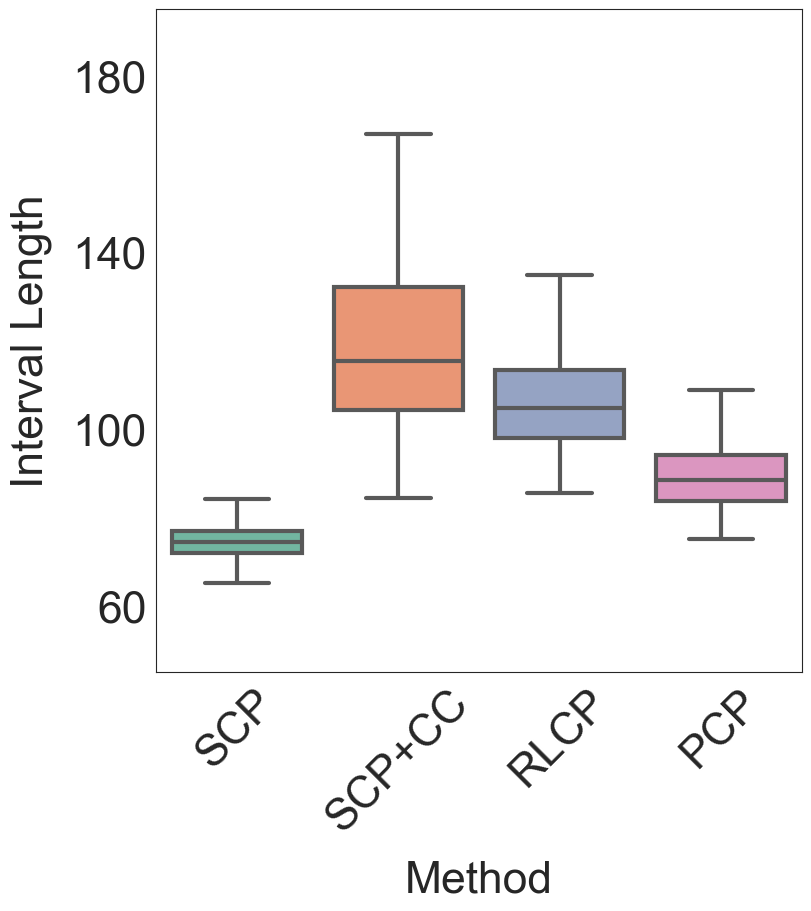

In [16]:
plt.figure(layout='constrained', figsize=(8,9))
sns.set_palette("Set2")
sns.boxplot(y='Width', x='Method',  data=df1,fliersize=0,linewidth=3,palette="Set2")
plt.ylim([45, 195])
plt.yticks([60,100,140,180])
plt.xlabel('Method', fontsize=32, labelpad = 15)
plt.ylabel('Interval Length', fontsize=32, labelpad = 15)
plt.yticks(fontsize=32)
plt.xticks(fontsize=32,rotation=45)
plt.show()

In [17]:
data = np.concatenate(
    [[c_1[:num_iterations], num_iterations*['SCP']],
      [c_2[:num_iterations], num_iterations*['SCP+CC']],
      [c_3[:num_iterations], num_iterations*['RLCP']],    
     [c_4[:num_iterations], num_iterations*['PCP']]
    ],axis=1)
df = pd.DataFrame(columns=['Coverage', 'Method'], data=data.T)
df['Coverage'] = df['Coverage'].astype("float64")

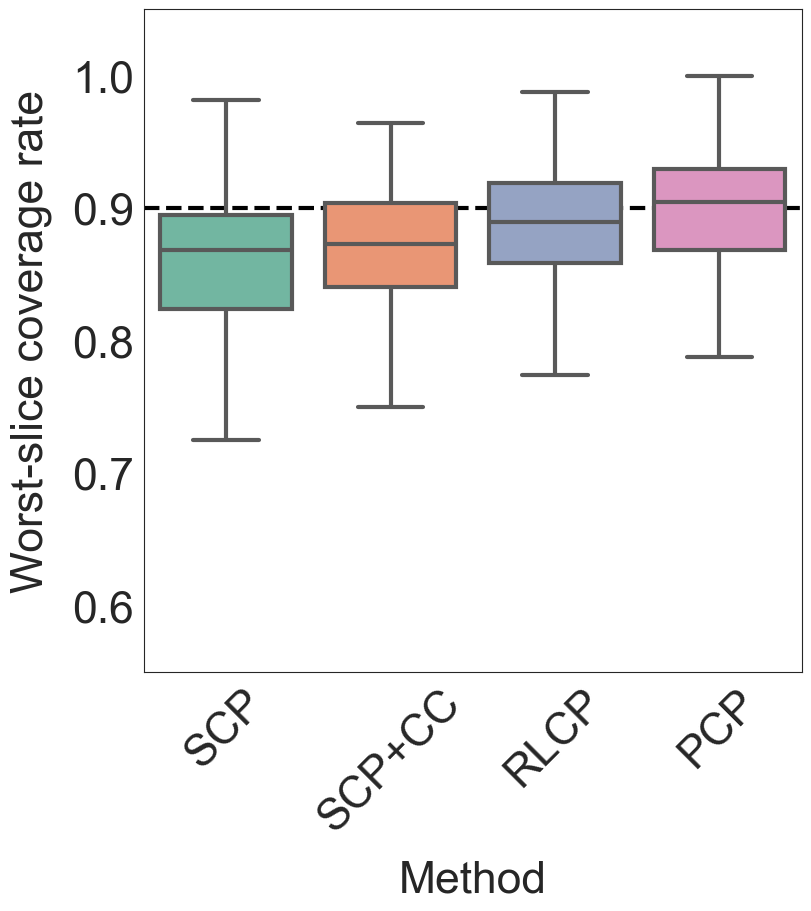

In [18]:
plt.figure(layout='constrained', figsize=(8,9))
plt.axhline(y=0.9, color='black', linestyle='--', linewidth=3) 
sns.set_style("white")
sns.color_palette("Set2")
sns.boxplot(y='Coverage', x='Method', data=df, fliersize=0,linewidth=3,palette="Set2")
plt.ylim([0.55,1.05])
plt.yticks([0.6, 0.7,0.8,0.9,1.0])
plt.xlabel('Method', fontsize=32, labelpad = 15)
plt.ylabel('Worst-slice coverage rate', fontsize=32, labelpad = 15)
plt.yticks(fontsize=32)
plt.xticks(fontsize=32,rotation=45)